In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090b_hw3_edit.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3: Convolutional Neural Networks


**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

In [3]:
try:
    import tensorflow_datasets as tfds
except ImportError:
    print("Installing tensorflow-datasets...")
    !pip install -q --no-warn-script-location tensorflow-datasets==4.9.4
    print("Done!\n⚠️ Please restart kernel for changes to take effect (Kernel > Restart)")

In [4]:
import pandas as pd

In [5]:
import os
import pathlib
import time
import zipfile
import random
import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import tarfile
import gdown
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
%pip install -q --no-warn-script-location tensorflow-datasets==4.9.4
import tensorflow_datasets as tfds

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tqdm

2025-04-02 21:07:38.393547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 21:07:38.393587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 21:07:38.394299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 21:07:38.399451: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Note: you may need to restart the kernel to use updated packages.


In [6]:
# TF GPU check
print(f"tensorflow version {tf.__version__}")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

tf.random.set_seed(2266)

tensorflow version 2.15.0
Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



2025-04-02 21:07:51.086311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:31:00.0, compute capability: 8.9


In [7]:
# measure notebook runtime
time_start = time.time()

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>


<a id="contents"></a>

## Notebook Contents

- [**PART 1: Building a Basic CNN Classifier**](#part1)

- [**PART 2: Regression with CNN**](#part2)

- [**PART 3: Image Segmentation**](#part3)

## About this Homework

In this homework, we will explore Convolutional Neural Networks (CNNs).

- In [PART 1](#part1), we will begin by building a CNN to classify CIFAR-10 images, a standard pedagogical problem.


- Then, in [PART 2](#part2), we will then see that CNNs are great for more than just classifying our images! They can serve as image input processing for a variety of tasks, as we will show by training a network on the CelebA dataset to rotate images of faces upright.

- Finally, [PART 3](#part3), we will look at a dataset of pet photos for image segmentation. This is a classification problem. But instead of assigning class probablities to the image as a whole, we assign class probabilities for each individual pixel, identifying what regions of the image belong to each class (e.g., 'pet' or 'background').  

**IMPORTANT NOTES:**

- Convolutional neural networks are computationally intensive.
- **We highly recommend that you train your model on a system using GPUs. For this, we recommend using the [GPU-enabled Jupyter environment](https://ood.huit.harvard.edu/pun/sys/dashboard/batch_connect/sys/ood-jupyterlab-spack-conda/cs1090b/session_contexts/new) provided to you as part of this course.** 
- Models that take hours to train on CPUs can be trained in just minutes when using GPUs.
- **To avoid getting frustrated by having to re-train your models every time you run your notebook, you should save your trained model weights for later use.** Model history dictionaries can also be saved to disk with `pickle` and checked with an `if not` condition. This is a great way to check if the model weights exist before training, preventing redundant retraining. Please, think of the penguins! 🐧

**KERNEL CRASHES:**

If your kernel crashes as you attempt to train your model, please check the following items:
- Models with too many parameters might not fit in GPU memory. Try reducing the size of your model.
- A large `batch_size` will attempt to load too many images in GPU memory. Avoid using a very large batch size.
- Avoid creating multiple copies of the data.

<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1: Building a Basic CNN Model


<a id="part1intro"></a>

## Overview

[Return to contents](#contents)

In this question, you will use Keras to create a convolutional neural network for predicting the "type of object" shown in each image from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset. This dataset contains 50,000 32x32 colored training images and 10,000 test images of the same size, with a total of 10 classes, representing the "type of object" shown in each image.

<a id="q11"></a>



<!-- BEGIN QUESTION -->

<div class='exercise'>
    
<b>1.1 Loading CIFAR-10 and Constructing the Model</b>
<hr>
<b>Q1.1.1 - Preprocessing</b>

<a id="q111"></a>

Load the CIFAR-10 dataset from the `tensorflow.keras.datasets.cifar10` import shown at the top of this notebook. Perform any preprocessing of the data that might be required for this dataset.
    
You may choose to load cifar10 as either a numpy array or as a Tensorflow Dataset.
</div>

In [8]:
# load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#(x_train,y_train), (x_test,y_test) = cifar.load_data()

#normalize pixel values to range [0,1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
# one hot encode the labels, 10 categories
y_train = to_categorical(y_train, 10)  
y_test = to_categorical(y_test, 10)
#y_train = to_categorical(y_train, 10) gives 10 class labels for the y output

#test-val split
validation_split = 0.2
val_size = int(len(x_train) * validation_split)
x_val = x_train[-val_size:]
y_val = y_train[-val_size:]
x_train = x_train[:-val_size]
y_train = y_train[:-val_size]



In [9]:
x_train.shape

(40000, 32, 32, 3)

In [10]:
y_train.shape

(40000, 10)

In [11]:
x_val.shape

(10000, 32, 32, 3)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1.2</b>

<a id="q112"></a>

Construct a classification model architecture using a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten. The layers don’t necessarily need to be in this order, and you can use as many of these types of layers as you’d like. 

  - You may choose to construct your own implementation of a well-known architecture like AlexNet or VGG16, or you can create an architecture of your own devising.

  - However, you MUST code the network yourself and not use a pre-written implementation. 

  - You must have multiple Conv2D layers.
</div>

In [12]:
def create_cnn_model(input_shape = (32,32,3), num_classes = 10):
    model = Sequential()
    #I want to add a convolutional block
    #w/ 64 3x3 filters each w/ 3 channels, then have pooling to extract the 
    #most important signals, then add dropout
    #and most likely repeat this process for more convolutional blocks

    #also want to increase the number of filters as we get deeper into the cnn 
    model.add(Conv2D(64, (3,3), padding = 'same', activation ='relu', input_shape = input_shape))
    #64 filters each 3x3, and there are 3 channels per filter
    model.add(Conv2D(64,(3,3),padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))

 # second convolutional block
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # third convolutional block
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #final dense layer - need to flatten first, then add the dense layer, dropout
    #then the output layer
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    
    
    return model

In [13]:
# create the model
CNN_model = create_cnn_model()
#compile w/ optimizer, loss, metric
CNN_model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                        

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 Model parameter growth</b>

<a id="q12"></a>

How does the number of total parameters change (e.g. linearly, exponentially, etc.) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture and increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship. 

**HINT:** Completing this question is far easier if you write a function that generates your desired architecture in 1.1.2, with arguments that allow you to easily rebuild the architecture with varying numbers of filters per layer.
    </div>

In [14]:
#answering the question how the total number of parameters increase
#as the number of filters per layer increases

# define a function that generates the architecture with varying numbers of filters per layer
def create_varying_cnn_model(input_shape=(32, 32, 3), num_classes=10, num_filters=None):
    model = Sequential()
    
    # first convolutional block
    model.add(Conv2D(num_filters[0], (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(num_filters[0], (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # second convolutional block
    model.add(Conv2D(num_filters[1], (3, 3), padding='same', activation='relu'))    
    model.add(Conv2D(num_filters[1], (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # third convolutional block
    model.add(Conv2D(num_filters[2], (3, 3), padding='same', activation='relu'))    
    model.add(Conv2D(num_filters[2], (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # flatten and fully connected Dense layers
    model.add(Flatten())    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model    


#list to store filter sizes and parameter counts
filter_sizes = []
param_counts = []

# test different filter configurations which we will loop through
filter_configs = [
    [16, 32, 64],
    [32, 64, 128],
    [64, 128, 256],
    [128, 256, 512],
    [256, 512, 1024]
]

for config in filter_configs:
    model = create_varying_cnn_model(num_filters=config)
    # get total parameters
    total_params = model.count_params()
    
    # store the data
    filter_sizes.append(config[0])  # Use the first filter size as representative
    param_counts.append(total_params)
    
    print(f"Filter configuration {config}: {total_params:,} parameters")





Filter configuration [16, 32, 64]: 602,010 parameters
Filter configuration [32, 64, 128]: 1,341,226 parameters
Filter configuration [64, 128, 256]: 3,248,202 parameters
Filter configuration [128, 256, 512]: 8,776,330 parameters
Filter configuration [256, 512, 1024]: 26,689,290 parameters



Parameter growth data:


First Filter Size  Total Parameters
0                 16            602010
1                 32           1341226
2                 64           3248202
3                128           8776330
4                256          26689290

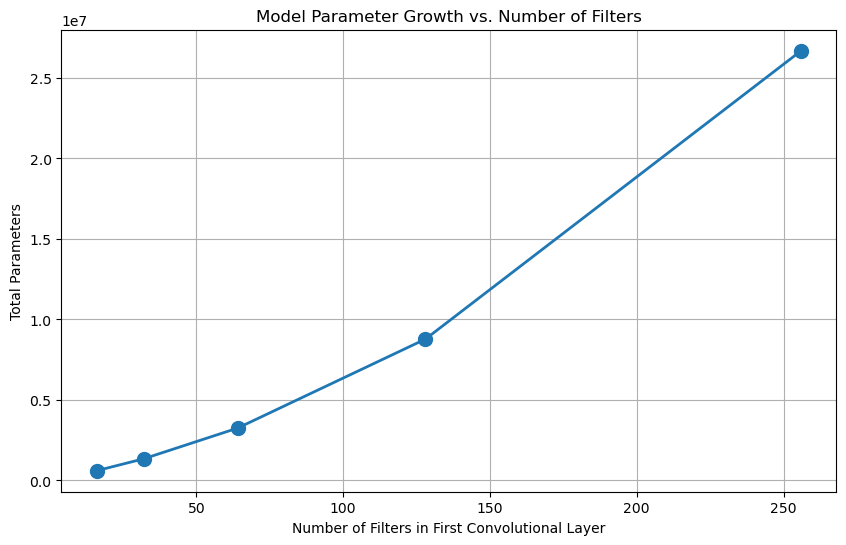

In [15]:
import pandas as pd
df_params = pd.DataFrame({
    'First Filter Size': filter_sizes,
    'Total Parameters': param_counts
})

#we should display the df to make it look nice
print("\nParameter growth data:")
display(df_params)


plt.figure(figsize=(10, 6))
plt.plot(filter_sizes, param_counts, 'o-', linewidth=2, markersize=10)
plt.title('Model Parameter Growth vs. Number of Filters')
plt.xlabel('Number of Filters in First Convolutional Layer')
plt.ylabel('Total Parameters')
plt.grid(True)
plt.show()


There seems to be an exponential growth in the number of total params, as a function of the amount of filters in a layer. This is due to a few reasons, but mainly -- there is this quadratic relationship because number of parameters (p) = n1 * k * k * n2, where k*k is the dimensions of the input, n1 = # channels of the input and n2 = the # of filters in the layer. n1 = n2 because each filter produces a feature map with n channels. So essentially we can represent p = $n^2*k^2$, and this points to this exponential or quadratic like relationship between the number of parameters and number of filters. As we increase the number of filters, p will increase exponentially.

<a id="q13"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>

<b>1.3 Choose a model, train and evaluate it</b>
<hr>    
<b>Q1.3.1</b>

<a id="q131"></a>

Print the model summary for your chosen architecture, and report the total number of parameters. Then train your model using the CIFAR-10 dataset, and `validation_split=0.2`. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs. Report your validation and test accuracies. You can achieve a test accuracy of over 75% in about 6 minutes of training.

**Hint:** It would be helpful to add code which either saves your model to a local directory if it is the first time you're training it or loads your model if a saved file version currently exists in that directory. This will not only help save time when you rerun your notebook, but it will also ensure reproducible results in the rest of Part 1.
</div>

In [19]:
from tensorflow.keras.models import load_model

In [82]:
# # define model save path
# model_path = 'cifar10_cnn_model.h5'
# history = None

# # check if model already exists - chatgpt helped us with this code
# if os.path.exists(model_path):
#     print("Loading existing model...")
#     model = load_model(model_path)
# else:
#     print("Creating and training new model...")
    
    # create CNN model - using the 32 filter architecture from our previous questions
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# create checkpoint callback to save the best model
checkpoint = ModelCheckpoint(model_path, 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# add early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# train the model
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=30,
                    validation_split=0.2,
                    callbacks=[checkpoint, early_stop],
                    verbose=1)

# load the best model (in case the last epoch wasn't the best)
model = load_model(model_path)

# print model summary
model.summary()



Epoch 1/30
238/250 [===========================>..] - ETA: 0s - loss: 1.7391 - accuracy: 0.3564
Epoch 1: val_accuracy improved from -inf to 0.46712, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


250/250 [==============================] - 3s 9ms/step - loss: 1.7281 - accuracy: 0.3610 - val_loss: 1.4694 - val_accuracy: 0.4671
Epoch 2/30
249/250 [============================>.] - ETA: 0s - loss: 1.3435 - accuracy: 0.5159
Epoch 2: val_accuracy improved from 0.46712 to 0.55813, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


250/250 [==============================] - 2s 8ms/step - loss: 1.3433 - accuracy: 0.5161 - val_loss: 1.2238 - val_accuracy: 0.5581
Epoch 3/30
248/250 [============================>.] - ETA: 0s - loss: 1.1371 - accuracy: 0.5945
Epoch 3: val_accuracy improved from 0.55813 to 0.63713, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


250/250 [==============================] - 2s 8ms/step - loss: 1.1359 - accuracy: 0.5951 - val_loss: 1.0307 - val_accuracy: 0.6371
Epoch 4/30
248/250 [============================>.] - ETA: 0s - loss: 1.0036 - accuracy: 0.6428
Epoch 4: val_accuracy improved from 0.63713 to 0.67000, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


250/250 [==============================] - 2s 8ms/step - loss: 1.0028 - accuracy: 0.6433 - val_loss: 0.9392 - val_accuracy: 0.6700
Epoch 5/30
238/250 [===========================>..] - ETA: 0s - loss: 0.9084 - accuracy: 0.6773
Epoch 5: val_accuracy improved from 0.67000 to 0.68400, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


250/250 [==============================] - 2s 8ms/step - loss: 0.9078 - accuracy: 0.6773 - val_loss: 0.9104 - val_accuracy: 0.6840
Epoch 6/30
250/250 [==============================] - ETA: 0s - loss: 0.8372 - accuracy: 0.7041
Epoch 6: val_accuracy improved from 0.68400 to 0.70800, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


250/250 [==============================] - 2s 9ms/step - loss: 0.8372 - accuracy: 0.7041 - val_loss: 0.8396 - val_accuracy: 0.7080
Epoch 7/30
249/250 [============================>.] - ETA: 0s - loss: 0.7831 - accuracy: 0.7253
Epoch 7: val_accuracy improved from 0.70800 to 0.73062, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


250/250 [==============================] - 2s 8ms/step - loss: 0.7834 - accuracy: 0.7253 - val_loss: 0.7821 - val_accuracy: 0.7306
Epoch 8/30
250/250 [==============================] - ETA: 0s - loss: 0.7307 - accuracy: 0.7423
Epoch 8: val_accuracy improved from 0.73062 to 0.73850, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


250/250 [==============================] - 2s 8ms/step - loss: 0.7307 - accuracy: 0.7423 - val_loss: 0.7588 - val_accuracy: 0.7385
Epoch 9/30
248/250 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.7585
Epoch 9: val_accuracy did not improve from 0.73850
250/250 [==============================] - 1s 4ms/step - loss: 0.6845 - accuracy: 0.7587 - val_loss: 0.7737 - val_accuracy: 0.7346
Epoch 10/30
247/250 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.7674
Epoch 10: val_accuracy improved from 0.73850 to 0.74425, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


250/250 [==============================] - 2s 8ms/step - loss: 0.6566 - accuracy: 0.7674 - val_loss: 0.7435 - val_accuracy: 0.7442
Epoch 11/30
249/250 [============================>.] - ETA: 0s - loss: 0.6173 - accuracy: 0.7806
Epoch 11: val_accuracy improved from 0.74425 to 0.74800, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


250/250 [==============================] - 2s 8ms/step - loss: 0.6171 - accuracy: 0.7808 - val_loss: 0.7447 - val_accuracy: 0.7480
Epoch 12/30
247/250 [============================>.] - ETA: 0s - loss: 0.5850 - accuracy: 0.7937
Epoch 12: val_accuracy did not improve from 0.74800
250/250 [==============================] - 1s 4ms/step - loss: 0.5845 - accuracy: 0.7937 - val_loss: 0.7435 - val_accuracy: 0.7461
Epoch 13/30
248/250 [============================>.] - ETA: 0s - loss: 0.5570 - accuracy: 0.8034
Epoch 13: val_accuracy improved from 0.74800 to 0.76500, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


250/250 [==============================] - 2s 8ms/step - loss: 0.5566 - accuracy: 0.8036 - val_loss: 0.7073 - val_accuracy: 0.7650
Epoch 14/30
248/250 [============================>.] - ETA: 0s - loss: 0.5240 - accuracy: 0.8146
Epoch 14: val_accuracy did not improve from 0.76500
250/250 [==============================] - 1s 4ms/step - loss: 0.5247 - accuracy: 0.8145 - val_loss: 0.7463 - val_accuracy: 0.7539
Epoch 15/30
242/250 [============================>.] - ETA: 0s - loss: 0.5049 - accuracy: 0.8205
Epoch 15: val_accuracy did not improve from 0.76500
250/250 [==============================] - 1s 4ms/step - loss: 0.5053 - accuracy: 0.8202 - val_loss: 0.7144 - val_accuracy: 0.7623
Epoch 16/30
250/250 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.8273
Epoch 16: val_accuracy improved from 0.76500 to 0.77012, saving model to model/cnn_2.2.3
INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


INFO:tensorflow:Assets written to: model/cnn_2.2.3/assets


Restoring model weights from the end of the best epoch: 13.
250/250 [==============================] - 2s 8ms/step - loss: 0.4826 - accuracy: 0.8273 - val_loss: 0.7130 - val_accuracy: 0.7701
Epoch 16: early stopping
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_69 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_33 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_70 (Conv2D)          (None, 

In [83]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest accuracy: {test_acc:.4f}")



Test accuracy: 0.7671


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3.2</b>

<a id="q132"></a> 

Plot the training loss and accuracy per epoch (both train and validation) for your chosen architecture.

</div>

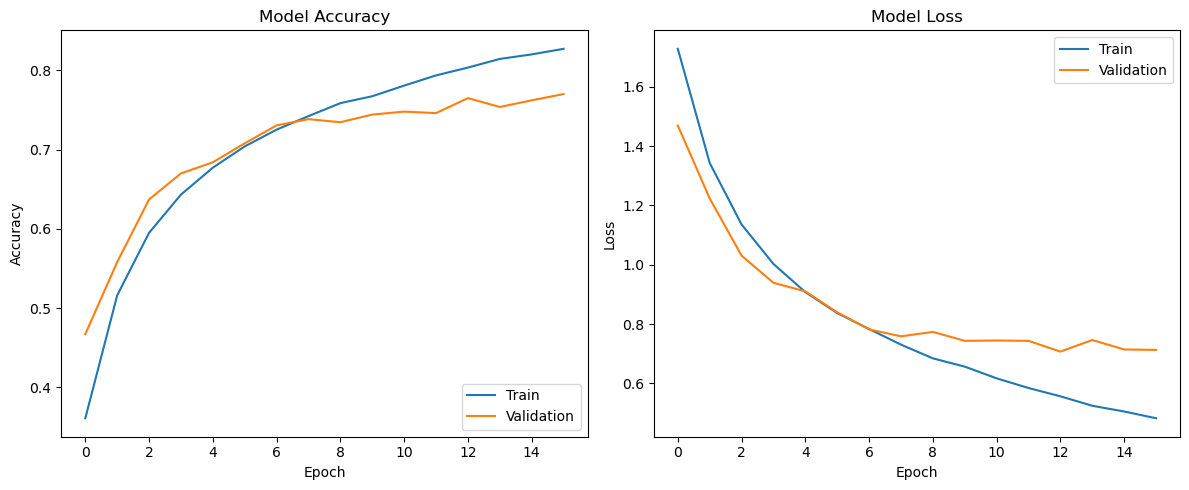

In [84]:
if history is not None:
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2: Regression with CNN 
<a id="part2intro"></a>
## Overview

[Return to contents](#contents)

**In this problem we will construct a neural network to predict how far a face is from being "upright"**. 

**Image orientation estimation**

Image orientation estimation with convolutional networks was first implemented in 2015 by Fischer, Dosovitskiy, and Brox in a paper titled ["Image Orientation Estimation with Convolutional Networks"](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf). In that paper, the authors trained a network to straighten a wide variety of images using the [Microsoft COCO dataset](https://cocodataset.org/#home). 

**The modified CelebA dataset**

In order to have a reasonable training time for a homework, we will be working on a subset of the problem where we just straighten images of faces. To do this:

- We will be using the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset of celebrity faces, where we assume that professional photographers have taken level pictures;


- The training will be supervised, with a rotated image (up to $\pm 60^\circ$) as an input, and the amount (in degrees) that the image has been rotated as a target. 

<a id="q21"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>
<b>2.1 Data preparation</b>
<hr>
<b>Q2.1.1</b>

<a id="q211"></a>

**Loading the CelebA Dataset.** Run the cells provided to automatically load the CelebA dataset if you are on the cluster. Otherwise it will be downloaded for you. This is a TensorFlow Dataset object. [TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from PART 1 where the entire dataset was loaded in as an array. Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`).

  - **All you need to do is run the provided code**:

    - The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and validation dataset `test_rot_ds`. 
    
**Note:** You do not need to create a separate validation anywhere in Part 2. We are just using train and test with no validation for simplicity.
    </div>

In [42]:
# Define paths and URL
cluster_data_dir = os.path.expanduser('~/142601/data/hw3')
local_data_dir = './data'
gdrive_url = 'https://drive.google.com/uc?id=13C6qxNmKlkW8ZRcFcc3N0GhmBeww8HDI'

# Check for cluster data directory first
if os.path.exists(cluster_data_dir):
    print(f"Using cluster dataset")
    data_dir = cluster_data_dir
    download = False
else:
    # Not on cluster, prepare local directory
    os.makedirs(local_data_dir, exist_ok=True)
    
    # If not already downloaded, get it from Google Drive
    if not os.path.exists(os.path.join(local_data_dir, 'celeb_a')):
        print("Downloading dataset...")
        targz_path = os.path.join(local_data_dir, 'celeb_a.tar.gz')
        gdown.download(gdrive_url, targz_path)
        
        # Extract archive
        with tarfile.open(targz_path) as tar:
            tar.extractall(path=local_data_dir)
        os.remove(targz_path)
    
    data_dir = local_data_dir
    download = False

# Load the dataset
train_celeb, test_celeb = tfds.load(
    "celeb_a",
    split=["train", "test"],
    shuffle_files=False,
    data_dir=data_dir,
    download=download,
)

Using cluster dataset


In [43]:
def normalize_image(img):
    """Normalize image to [0, 1] range."""
    return tf.cast(img, tf.float32)/255.

@tf.function
def scipy_rotate(image, angle):
    """Efficient rotation using SciPy's ndimage."""
    rotated = tf.numpy_function(
        lambda img, ang: ndimage.rotate(img, ang, reshape=False, order=1),
        [image, angle],
        tf.float32
    )
    rotated.set_shape(image.shape)
    rotated = tf.image.resize_with_crop_or_pad(rotated, 140, 120)
    return rotated

@tf.function
def tf_random_rotate_helper(image):
    """Apply random rotation."""
    image = normalize_image(image)
    deg = tf.random.uniform([], -60.0, 60.0)
    rotated = scipy_rotate(image, deg)
    return rotated, deg

@tf.function
def tf_random_rotate_image(element):
    """Process dataset element."""
    image = element['image']
    rotated, angle = tf_random_rotate_helper(image)
    rotated.set_shape((140, 120, 3))
    return rotated, angle

In [44]:
# Pipeline for creating randomly rotated images with their target labels being 
# the amount they were rotated, in degrees.
train_rot_ds = train_celeb.map(
    tf_random_rotate_image,
    num_parallel_calls=tf.data.AUTOTUNE)

test_rot_ds = test_celeb.map(
    tf_random_rotate_image,
    num_parallel_calls=tf.data.AUTOTUNE)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1.2</b>

<a id="q212"></a>

**Taking a look.** In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. **HINT:** one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more information.

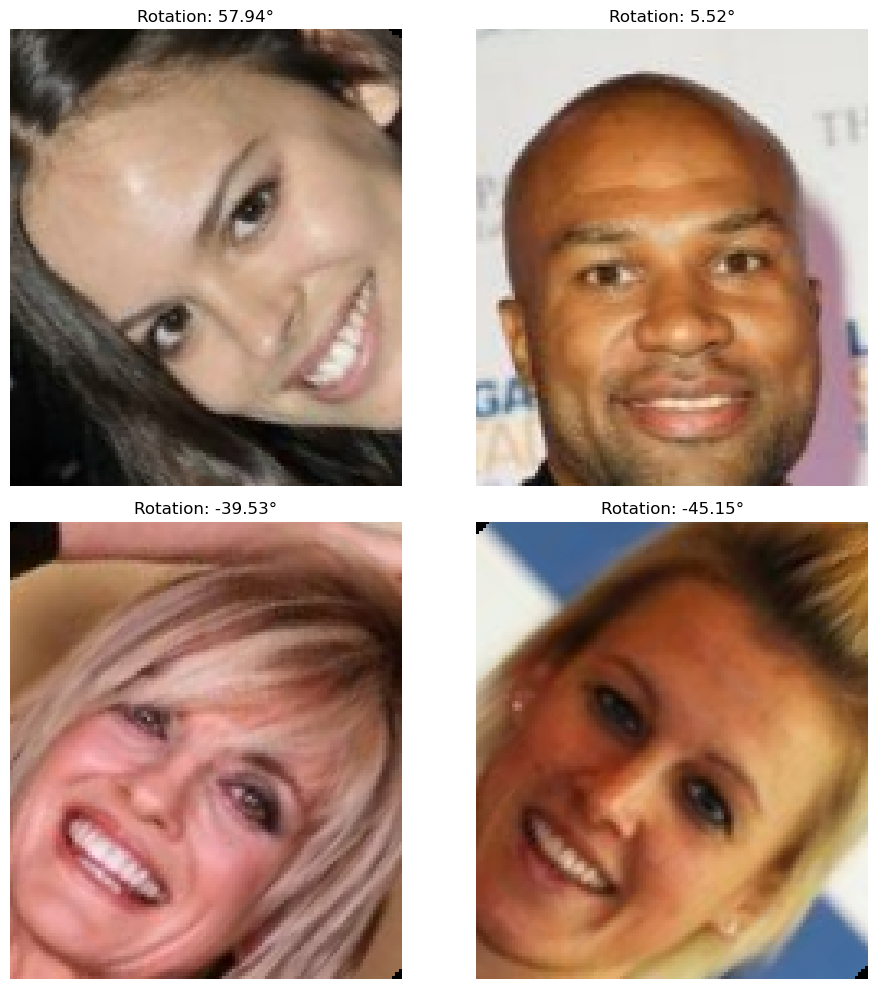

In [45]:
#plotting at least 4 rotated images from train_rot_ds dataset

fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.flatten()

#getting 4 rotated images from train_rot_ds
samples = list(train_rot_ds.take(4).as_numpy_iterator())
#converts the dataset to a Python iterator that yields NumPy arrays.

for i, (image,angle) in enumerate(samples):
    axes[i].imshow(image)
    axes[i].set_title(f"Rotation: {angle:.2f}°")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

<a id="q22"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>
<b>2.2 Building and training your CNN</b>
<hr>
<a id="q221"></a>
<b>Q2.2.1 Compiling your model.</b>
    
Construct a model with multiple Conv layers and any other layers you think would help. Be certain to print your model summary as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we have been able to do it with substantially fewer. 
    
**Note:** Again, it is fine to attempt your own implementation of a well-known architecture, but you may not load any pre-constructed models. The network must be built layer-by-layer from your own code.
    </div>

In [46]:
for images, angles in train_rot_ds.take(1):
    print(f"Image shape: {images.shape}")
    print(f"Angle: {angles}")


Image shape: (140, 120, 3)
Angle: 57.94377136230469


In [47]:
# train the model on a smaller sample of the data just to make
#thigns faster

BATCH_SIZE = 64
train_sample = train_rot_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_sample = test_rot_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 

In [48]:

# address potential ics
# keep image + output map dimensions same [padding = same]

model_partner = Sequential([
    layers.Input(shape=(140, 120, 3)),  

    # 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(), 
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # flat + dense
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)  
])

model_partner.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 140, 120, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 140, 120, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_41 (Conv2D)          (None, 140, 120, 32)      9248      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 70, 60, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 70, 60, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 70, 60, 64)       

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.2 Training your model</b>

<a id="q222"></a>

Train your model. Please note that the `model.fit()` argument syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `.fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. However, your final model MUST be trained on all the available training data! You should achieve test MSEs of less than 9, corresponding roughly to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.
    </div>

In [49]:
#training model using whole dataset
final_model = model_partner
BATCH_SIZE = 64
train_ds = train_rot_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_rot_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# define callbacks for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# reduce learning rate when plateauing
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# create model checkpoint to save the best model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model/best_rotation_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# compile
final_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# training model
print("Training the model...")
history = final_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)
# final_model.summary() 
# evaluate the model on the test dataset
test_loss, test_mae = final_model.evaluate(test_ds)
print(f"\nFinal test loss (MSE): {test_loss:.4f}")
print(f"Final test MAE: {test_mae:.4f}")
print(f"Approximate degree error: ±{np.sqrt(test_loss):.2f}°")



Training the model...
Epoch 1/3
2544/2544 [==============================] - ETA: 0s - loss: 68.4812 - mae: 5.6267
Epoch 1: val_loss improved from inf to 16.67720, saving model to model/best_rotation_model
2544/2544 [==============================] - 210s 79ms/step - loss: 68.4812 - mae: 5.6267 - val_loss: 16.6772 - val_mae: 2.8685 - lr: 0.0010
Epoch 2/3
2543/2544 [============================>.] - ETA: 0s - loss: 28.0427 - mae: 3.8668
Epoch 2: val_loss improved from 16.67720 to 7.38420, saving model to model/best_rotation_model
2544/2544 [==============================] - 195s 77ms/step - loss: 28.0420 - mae: 3.8668 - val_loss: 7.3842 - val_mae: 1.9380 - lr: 0.0010
Epoch 3/3
2543/2544 [============================>.] - ETA: 0s - loss: 22.5260 - mae: 3.4763
Epoch 3: val_loss improved from 7.38420 to 6.16810, saving model to model/best_rotation_model
312/312 [==============================] - 20s 62ms/step - loss: 6.1656 - mae: 1.6924

Final test loss (MSE): 6.1656
Final test MAE: 1.692

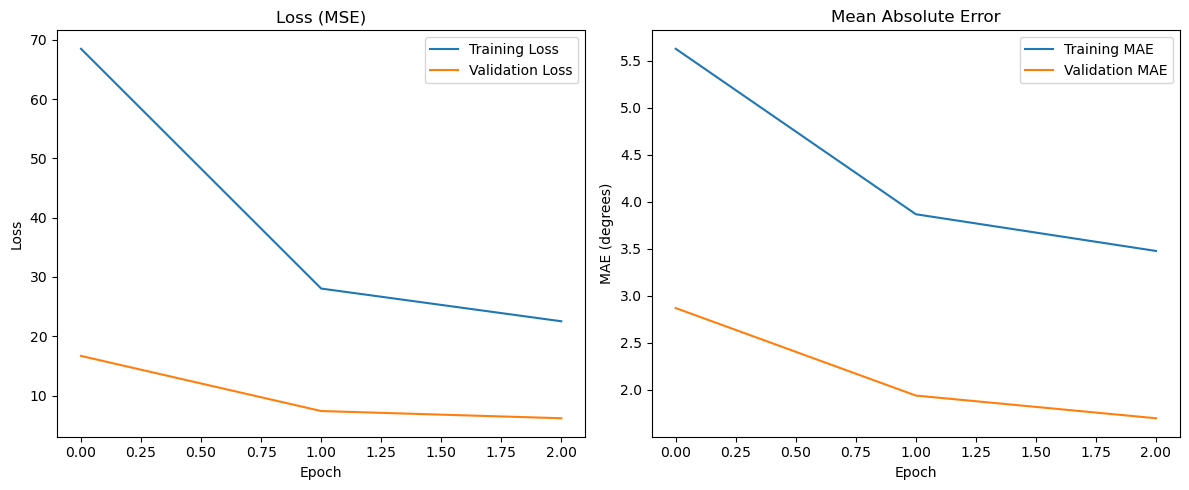

In [50]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE (degrees)')
plt.legend()

plt.tight_layout()
plt.show()

In [51]:

# Display some predictions
print("\nSample predictions:")
for images, angles in test_ds.take(1):
    predictions = final_model.predict(images)
    for i in range(min(5, len(predictions))):
        print(f"True angle: {angles[i].numpy():.2f}°, Predicted angle: {predictions[i][0]:.2f}°, " 
              f"Error: {abs(angles[i].numpy() - predictions[i][0]):.2f}°")



Sample predictions:
2/2 [==============================] - 1s 4ms/step
True angle: 57.94°, Predicted angle: 57.43°, Error: 0.51°
True angle: 5.52°, Predicted angle: 10.94°, Error: 5.42°
True angle: -45.15°, Predicted angle: -43.46°, Error: 1.69°
True angle: -57.56°, Predicted angle: -46.00°, Error: 11.57°
True angle: -13.38°, Predicted angle: -13.98°, Error: 0.60°


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.3 Saving and loading your weights</b>

<a id="q223"></a>

Save your model weights to the path `model/your_model_name` where `your_model_name` is whatever filename prefix you want. Then reload your weights from that same path.
    </div>

In [52]:
#ChatGPT code for helping us save and load the weights! 
# Define the path for saving the model weights
model_path = 'model/cnn_2.2.3'

# Create the directory if it doesn't exist
import os
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the model weights
final_model.save_weights(model_path)
print(f"Model weights saved to {model_path}")

# Reload the model weights
final_model.load_weights(model_path)
print(f"Model weights loaded from {model_path}")

# Verify the model works after loading weights
test_loss, test_mae = final_model.evaluate(test_ds, verbose=0)
print(f"After loading weights - Test loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Model weights saved to model/cnn_2.2.3
Model weights loaded from model/cnn_2.2.3
After loading weights - Test loss: 6.1708, Test MAE: 1.6917


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.4 Evaluating your model</b>

<a id="q224"></a>

Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like the image shown below. This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

![straightened face](data/straightened.png)
    
**Hint:** Your network expects its input to have an explicit 'batch' dimension (the 1st dimension). If you use `take()` to get one image from your dataset, you will need to add this extra batch dimension to it in order to pass it to `predict()`. There are several ways to do this. You can check out [this SO post](https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image) for some ideas.

In [53]:
def rot_resize(img, deg):
    """Rotate image by specified degrees and resize to 140x120."""
    # Ensure the input is a numpy array
    if isinstance(img, tf.Tensor):
        img = img.numpy()
    
    # Apply rotation using SciPy's ndimage
    rotimg = ndimage.rotate(img, deg, reshape=False, order=3)
    
    # Clip values to valid range
    rotimg = np.clip(rotimg, 0., 1.)
    
    # Resize using TensorFlow's crop_and_resize
    rotimg = tf.convert_to_tensor(rotimg, dtype=tf.float32)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg, 140, 120)
    
    # Convert back to numpy for matplotlib
    return rotimg.numpy()

In [54]:
### the original function defined has flipped the photos horizontally instead of vertically - so I adress it here. 

def rot_resize(img, deg):
    """Rotate image by specified degrees and resize to 140x120."""
    # Apply NEGATIVE rotation to correct the image
    rotimg = ndimage.rotate(img, -deg, reshape=False, order=3)      
    # Ensure the input is a numpy array
    if isinstance(img, tf.Tensor):
        img = img.numpy()
    
    # Clip values to valid range
    rotimg = np.clip(rotimg, 0., 1.)
    
    # Resize using TensorFlow's crop_and_resize
    rotimg = tf.convert_to_tensor(rotimg, dtype=tf.float32)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg, 140, 120)
    
    return rotimg.numpy() 

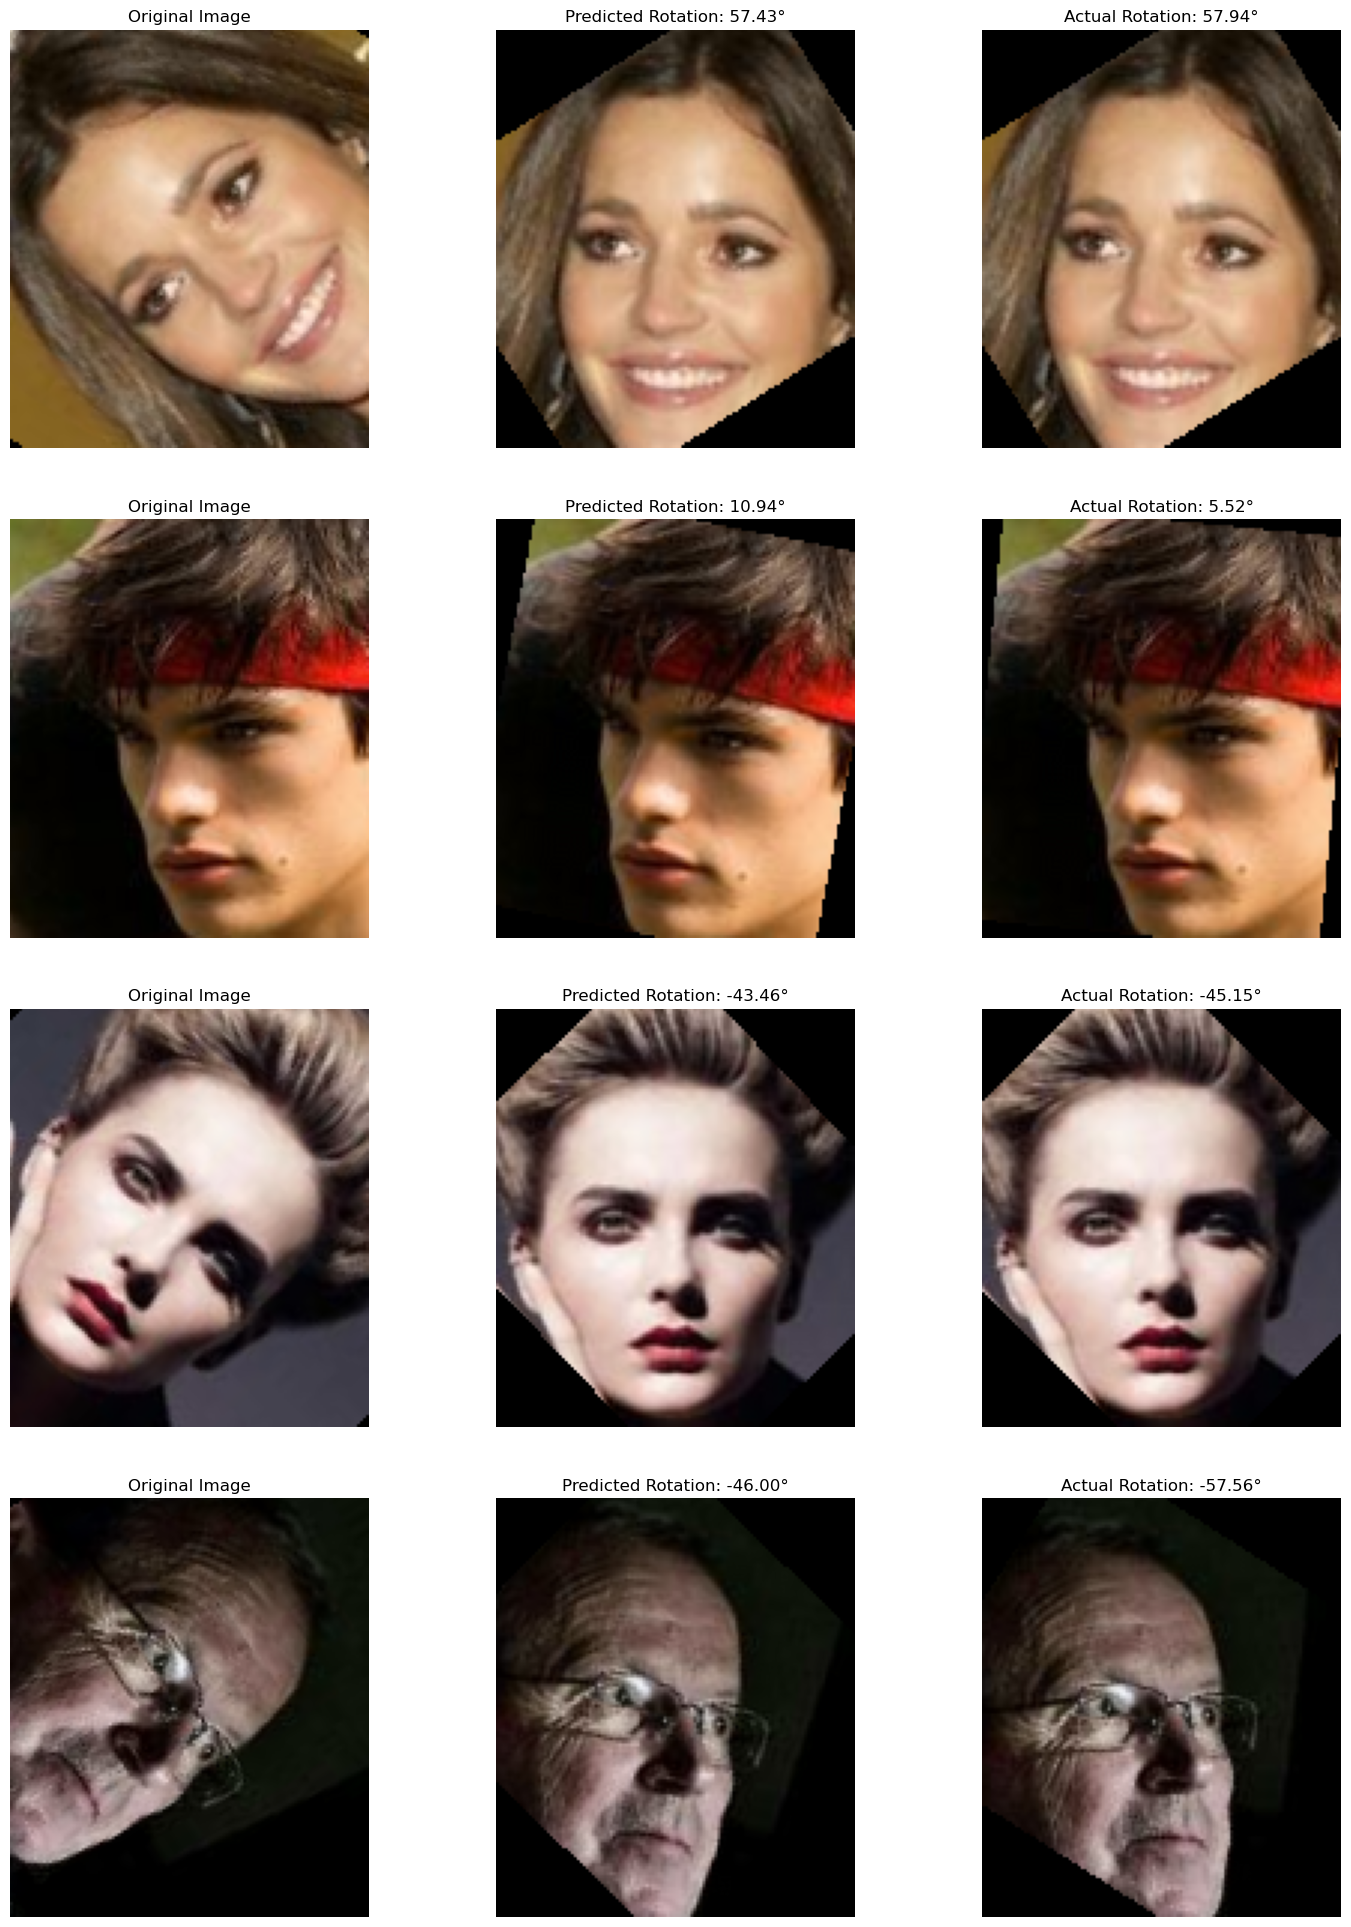

In [55]:


# Get 4 test images and their rotations
test_images = []
test_rotations = []

# Get 4 images and their rotations from the test dataset
for img, rot in test_rot_ds.take(4):
    test_images.append(img.numpy())
    test_rotations.append(rot.numpy())

# Create a figure with 4 rows and 3 columns
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
fig.tight_layout(pad=3.0)

# For each test image
for i in range(4):
    img = test_images[i]
    actual_rotation = test_rotations[i]  # Get the actual rotation value
    
    # Add batch dimension for prediction
    img_batch = tf.expand_dims(img, axis=0)
    
    # Predict rotation
    predicted_rotation = final_model.predict(img_batch, verbose=0)[0][0]
    
    # Original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')
    
    # Predicted straightened 
    straightened_img_pred = rot_resize(img, predicted_rotation)
    axes[i, 1].imshow(straightened_img_pred)
    axes[i, 1].set_title(f"Predicted Rotation: {predicted_rotation:.2f}°")
    axes[i, 1].axis('off')
    
    # Target straightened image
    straightened_img_target = rot_resize(img, actual_rotation)
    axes[i, 2].imshow(straightened_img_target)
    axes[i, 2].set_title(f"Actual Rotation: {actual_rotation:.2f}°")
    axes[i, 2].axis('off')

plt.show()

<!-- BEGIN QUESTION -->

<div class='exercise'>
<a id="q23"></a>
<b>2.3 Further Analysis</b>
<hr>
<b>Q2.3.1 Correct an image of your choosing</b>

<a id="q231"></a>

Find an image or image(s) (not from the provided test/training sets), or make your own; it does not necessarily have to be a human face. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.], and use your network to correct it.

![Confused Chris](data/chrisprattcorrection.png)
    
**Note:** Please do *not* upload your custom image as a separate file with your notebook submission. It is sufficient to display your results in the cell output.
    </div>

In [56]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import requests
from io import BytesIO
import os

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(140, 120)):
    try:
        
        # Local file
        img = Image.open(image_path)
        
        # Resize the image
        img = img.resize(target_size)
        
        # Convert to numpy array and normalize to [0, 1]
        img_array = np.array(img) / 255.0
        
        return img_array
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Path to the image
# image_path = 'Rick-Astley-Never-Gonna-Give-You-Up-Remastered-Header.jpg'
image_path = 'chrispratt.jpg'

# Load and preprocess the image
custom_image = load_and_preprocess_image(image_path)


1/1 [==============================] - 0s 79ms/step


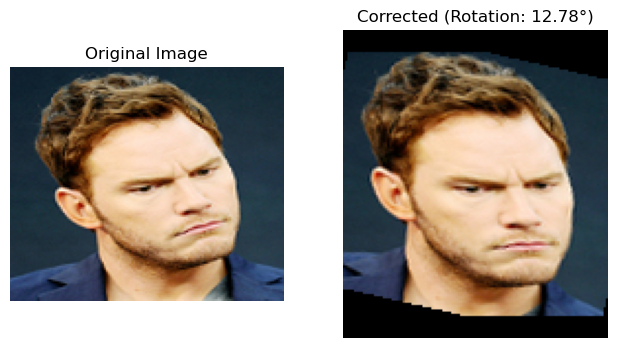

In [57]:
if custom_image is not None:
    # Display the original image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(custom_image)
    plt.title("Original Image")
    plt.axis('off')
    
    img_batch = tf.expand_dims(custom_image, axis=0)
    
     # Predict rotation
    img_batch_transposed = tf.transpose(img_batch, [0, 2, 1, 3])
    predicted_rotation = final_model.predict(img_batch_transposed, verbose=1)[0][0]
    

    # Display the predicted straightened image
    straightened_img_pred = rot_resize(custom_image, predicted_rotation)
    plt.subplot(1, 3, 2)
    plt.imshow(straightened_img_pred)
    plt.title(f"Corrected (Rotation: {predicted_rotation:.2f}°)")
    plt.axis('off')
    
    # # Display the original image again for comparison
    # plt.subplot(1, 3, 3)
    # plt.imshow(custom_image)
    # plt.title("Original for Comparison")
    # plt.axis('off')
    
    # plt.tight_layout()
    # plt.show()
else:
    print("Failed to load the image. Please check the path or URL.")

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 3: Image Segmentation
<a id="part3intro"></a>
## Overview

[Return to contents](#contents)

In this section, we will use the Oxford-IIIT Pet dataset to design a model for an image segmentation task.

[Semantic image segmentation](https://arxiv.org/abs/2302.06378) is a computer vision application where we assign a semantically meaningful label, or class, to every pixel in the image. For example, a camera on a self-driving car would segment the imagery around it into semantic labels such as "Road", "Person", "Bike", etc.

Our  dataset contains images of various pet breeds along with their corresponding segmentation masks. Each raw image is 500x403 with three RGB channels, while the corresponding mask is of the same size but contains only a single channel, indicating the pixel class.

For simplicity, we resize both the images and masks to 64x64 to speed up training.
We have also have provided all the necessary preprocessing code for you as well as some functions for visualization.

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 3: Image Segmentation
<a id="part3intro"></a>
## Overview

[Return to contents](#contents)

In this section, we will use the Oxford-IIIT Pet dataset to design a model for an image segmentation task.

[Semantic image segmentation](https://arxiv.org/abs/2302.06378) is a computer vision application where we assign a semantically meaningful label, or class, to every pixel in the image. For example, a camera on a self-driving car would segment the imagery around it into semantic labels such as "Road", "Person", "Bike", etc.

Our  dataset contains images of various pet breeds along with their corresponding segmentation masks. Each raw image is 500x403 with three RGB channels, while the corresponding mask is of the same size but contains only a single channel, indicating the pixel class.

For simplicity, we resize both the images and masks to 64x64 to speed up training.
We have also have provided all the necessary preprocessing code for you as well as some functions for visualization.

In [58]:
# Load the dataset with tensorflow-datasets
ds_source = tfds.load(
    'oxford_iiit_pet',
    split='test', # train set has corrupted images :(
    as_supervised=False, # we done need the dog breed labels
    download=True,
)

# Check the first example
example = next(iter(ds_source))
print(example.keys())
print(f"The raw image shape is: {example['image'].shape}")
print(f"The raw segmentation mask shape is: {example['segmentation_mask'].shape}")

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
The raw image shape is: (500, 403, 3)
The raw segmentation mask shape is: (500, 403, 1)


In [59]:
def preprocess(sample, reduce_class=False, resize_dim=64):
    """
    Complete preprocessing function that:
    1. Resizes image and mask to (resize_dim, resize_dim)
    2. Normalizes image to [0,1] range
    3. Remaps class indices to be more intuitive
    4. Optionally reduces to 2 classes
    5. Clips pixel values in case of corrupted jpegs
    6. Returns (image, mask) tuple
    """
    image = sample['image']
    mask = sample['segmentation_mask']

    # Resize using bilinear interpolation for image and nearest neighbor for mask
    image = tf.image.resize(image, [resize_dim, resize_dim], method='bilinear')
    mask = tf.image.resize(mask, [resize_dim, resize_dim], method='nearest')

    # Normalize the image: convert from [0, 255] to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Convert mask values from 1-indexed to 0-indexed
    mask = tf.cast(mask, tf.int32) - 1

    # Remap classes to be more intuitive
    # Current: 0-pet border, 1-background, 2-pet interior
    # Desired: 0-background, 1-border, 2-center
    new_mask = tf.zeros_like(mask)
    new_mask = tf.where(mask == 1, 0, new_mask)  # Map old background (1) to new background (0)
    new_mask = tf.where(mask == 0, 1, new_mask)  # Map old border (0) to new border (1) 
    new_mask = tf.where(mask == 2, 2, new_mask)  # Keep center as class 2
    
    # Reduce problem difficulty if requested
    if reduce_class:
        # Combine border and center into a single "pet" class
        # Now we have: 0-background, 1-pet (both border and center)
        new_mask = tf.where(new_mask > 0, 1, 0)

    # Handle corrupt JPEG data by ensuring valid values
    image = tf.clip_by_value(image, 0.0, 1.0)

    # Always return (image, mask) tuple
    return image, new_mask

In [60]:
# Helper functions for visualization
def visualize_image_and_mask(dataset, num_examples=5):
    """Visualizes image and segmentation mask pairs from the dataset."""
    for i, (image, mask) in enumerate(dataset.take(num_examples)):
        # Convert to numpy arrays
        image = image.numpy()
        mask = mask.numpy().squeeze()
        
        # Convert normalized image to uint8 for display
        if image.dtype == np.float32 and image.max() <= 1.0:
            display_image = (image * 255.0).astype('uint8')
        else:
            display_image = image.astype('uint8')
        
        mask = mask.astype(int)
        
        # Visualize
        plt.figure(figsize=(8, 4))

        # Plot the image
        plt.subplot(1, 2, 1)
        plt.imshow(display_image)
        plt.title("Image")
        plt.axis("off")

        # Plot the segmentation mask
        plt.subplot(1, 2, 2)
        cmap_choice = 'gray' if mask.max() <= 1 else 'viridis'
        plt.imshow(mask, cmap=cmap_choice, vmin=0, vmax=mask.max())
        plt.title("Segmentation Mask")
        plt.axis("off")

def visualize_predictions(dataset, model, num_examples=5, show_iou=False):
    
    """
    Visualizes predictions from a segmentation model alongside ground truth.
    
    Args:
        dataset: TensorFlow dataset containing images and masks
        model: Trained segmentation model
        num_examples: Number of examples to visualize
        show_iou: Whether to compute and display IoU metrics (default: False)
    """
    shuffled_dataset = dataset.shuffle(buffer_size=200)
    
    for i, (images, masks) in enumerate(shuffled_dataset.take(num_examples)):
        # Check if the dataset is batched
        if len(images.shape) == 4:  # Batched data
            batch_size = images.shape[0]
            random_index = random.randint(0, batch_size - 1)
            image_for_pred = images[random_index]
            mask = masks[random_index]
        else:  # Unbatched data
            image_for_pred = images
            mask = masks
            
        # Convert to numpy and prepare for display
        display_image = (image_for_pred * 255.0).numpy().astype('uint8')
        
        # Predict the segmentation mask
        with tf.device('/CPU:0'):
            pred_mask = model.predict(image_for_pred[tf.newaxis, ...], verbose=0)
        pred_mask = tf.argmax(pred_mask, axis=-1)[0]

        
        # Calculate metrics for this example
        true_mask = mask.numpy().squeeze()
        pred_mask_np = pred_mask.numpy().squeeze()
        
        # Calculate pixel-wise accuracy
        accuracy = (true_mask == pred_mask_np).mean()
        
        # Visualize
        plt.figure(figsize=(12, 4))
        
        # Plot the input image
        plt.subplot(1, 3, 1)
        plt.imshow(display_image)
        plt.title("Input Image")
        plt.axis("off")
        
        # Plot the ground truth mask
        plt.subplot(1, 3, 2)
        cmap_choice = 'gray' if true_mask.max() <= 1 else 'viridis'
        plt.imshow(true_mask, cmap=cmap_choice, vmin=0, vmax=true_mask.max())
        plt.title("Ground Truth Mask")
        plt.axis("off")
        
        # Plot the predicted mask with metrics in the title
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_np, cmap=cmap_choice, vmin=0, vmax=true_mask.max())
        
        if show_iou:
            # Calculate IoU for this example
            intersection = np.logical_and(true_mask, pred_mask_np).sum()
            union = np.logical_or(true_mask, pred_mask_np).sum()
            iou = intersection / union if union > 0 else 1.0
            plt.title(f"Predicted Mask\nAcc: {accuracy:.2%} | IoU: {iou:.2%}")
        else:
            plt.title(f"Predicted Mask\nAcc: {accuracy:.2%}")
            
        plt.axis("off")
        plt.tight_layout()

#RASTHMI SAID I COULD DO THE BELOW FUNCTION 
def visualize_predictions_with_threshold(dataset, model, threshold=0.3, num_samples=3):
    """Visualize model predictions with a custom threshold"""
    for i, (image, true_mask) in enumerate(dataset.take(num_samples)):
        # Get prediction
        pred_mask = model.predict(tf.expand_dims(image, 0), verbose=0)
        pred_mask = tf.squeeze(pred_mask)
        
        # Apply threshold
        pred_mask_binary = tf.cast(pred_mask > threshold, tf.float32)
        
        # Plot
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("True Mask")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_binary, cmap='gray')
        plt.title(f"Predicted Mask (threshold={threshold})")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1 Deep CNN for Image Segmentation</b>

<a id="q31"></a>

Here you'll design a segmentation model that utilizes convolutional layers and skip connections. The model should perform a binary classification task, predicting the class for each pixel which is compared to the ground truth segmentation mask. 

Minimum Requirements:
- A reasonably deep CNN architecture (you should be able to get above 80% validation accuracy with only 90 seconds of training)
- Accepts an input size of 64 × 64 × 3 and performs pixel-level binary classification.
- At least four skip connections placed appropriately.
- Compile the model with an appropriate loss function and include accuracy as an evaluation metric.
- Set the model name to `model_deepcnn`
- Assign the result of `model_deepcnn.fit()` to a variable named `history_model_deepcnn`.

We've created a train and validation set for you below.

**HINT:** Typically, for binary classification we utilize the sigmoid activation function with a single output unit. That can be an appropriate method for this task as well, where we have a single output filter. However, considering a 2-class classification with a softmax activation function and two output units will also work. You may find a difference in performance between the two methods. Be sure you are selecting the appropriate loss for your choice.
    </div>

In [61]:
# Create processed binary segmentation dataset
ds_2c = ds_source.map(lambda sample: preprocess(sample, reduce_class=True),
                               num_parallel_calls=tf.data.AUTOTUNE)
# 85/15 train-test split
ds_2c_train, ds_2c_test = tf.keras.utils.split_dataset(ds_2c, left_size=0.85)
# Reserve 20% of train as validation
ds_2c_train, ds_2c_val = tf.keras.utils.split_dataset(ds_2c, left_size=0.80)

# Dataset sizes
print("Train:", ds_2c_train.cardinality().numpy())
print("Validation:", ds_2c_val.cardinality().numpy())
print("Test:", ds_2c_test.cardinality().numpy())

Train: 2935
Validation: 734
Test: 550


In [62]:
ds_2c_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64, 64, 1), dtype=tf.int32, name=None))>

Here are some of the images and their corresponding segmentation masks. The segmentation mask categorizes each pixel into two classes: "background" or "pet".

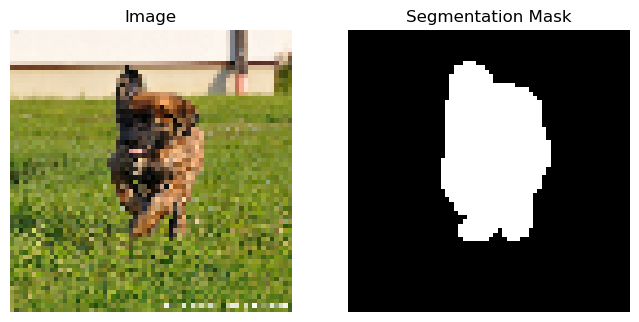

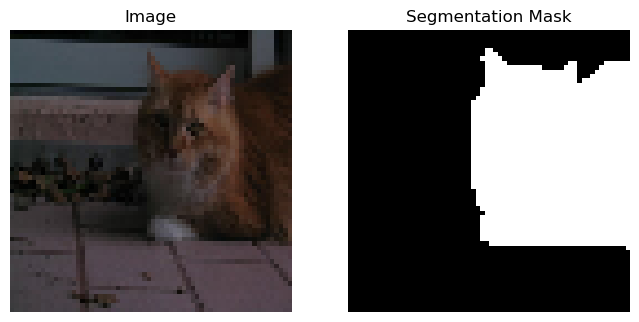

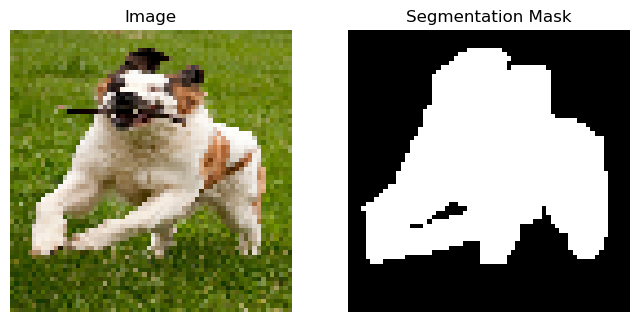

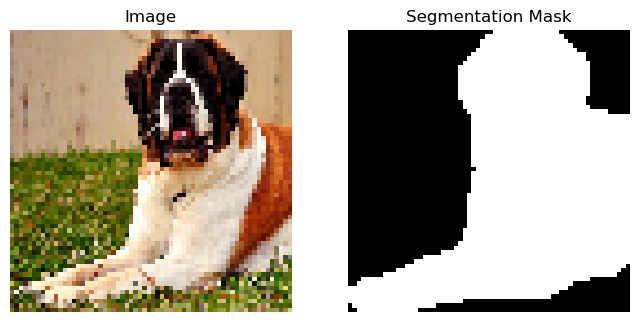

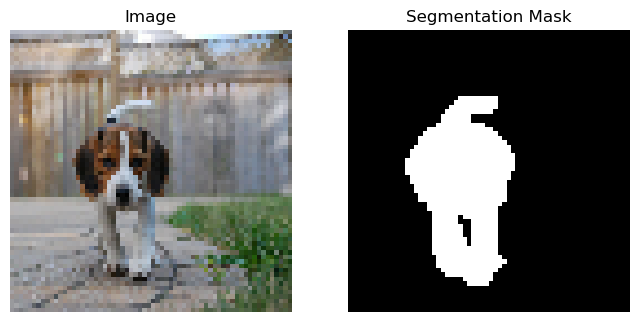

In [63]:
# Visualize 5 examples from the training split
visualize_image_and_mask(ds_2c_train)

In [64]:
#so this is a unet model because we are creating an image segmentation model
#input is 64x64, 3 channels
def create_unet_model(input_shape=(64,64,3)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    #encoder and first block
    #layer = tf.keras.layers.typeoflayer(kwargs)(input)
    #block 1 - two convolutional layers and pooling layer. pass in input
    #then pass in conv1
    conv1 = tf.keras.layers.Conv2D(64,3,activation='relu', padding = 'same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64,3,activation='relu', padding = 'same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)

    #block2
    conv2 = tf.keras.layers.Conv2D(128,3,activation='relu',padding='same')(pool1)
    conv2= tf.keras.layers.Conv2D(128,3,activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
    #block 3
    conv3 = tf.keras.layers.Conv2D(256,3,activation='relu',padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256,3,activation='relu',padding = 'same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv3)
    
    # block 4
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # middle block 5
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # decoder (upsampling path with skip connections)
    # block 6 and first skip connection
    up6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2,2),padding = 'same')(conv5)
    concat6 = tf.keras.layers.Concatenate()([up6, conv4])  # skip connection
    #concat6 = tf.keras.layers.Concatenate()([up6,conv4])
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    # block 7 - skip connection 2
    up7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.Concatenate()([up7, conv3])  # Skip connection
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    # block 8 - skip connection 3
    up8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    concat8 = tf.keras.layers.Concatenate()([up8, conv2])  # Skip connection
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    # block 9 - skip connection 4
    up9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    concat9 = tf.keras.layers.Concatenate()([up9, conv1])  # Skip connection
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # output layer - using sigmoid for binary classification
    #change to softmax or make a change to visualize prediction function
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    # create and return the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='model_deepcnn')
    return model

# create the model
model_deepcnn = create_unet_model()

# compile the model with binary crossentropy loss
model_deepcnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model_deepcnn.summary()    
    

Model: "model_deepcnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 64, 64, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_46 (Conv2D)          (None, 64, 64, 64)           36928     ['conv2d_45[0][0]']           
                                                                                                  
 max_pooling2d_23 (MaxPooli  (None, 32, 32, 64)           0         ['conv2d_46[0][0]']           
 ng2D)                                                                                

In [65]:

# prepare the datasets for training
BATCH_SIZE = 16
BUFFER_SIZE = 1000

# def one_hot_mask(x, y):
#     y = tf.cast(y, tf.int32)
#     y = tf.one_hot(y[..., 0], depth=2)  # Convert from (64, 64, 1) → (64, 64, 2)
#     return x, y

# train_dataset = ds_2c_train.map(one_hot_mask).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# val_dataset = ds_2c_val.map(one_hot_mask).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset = ds_2c_train.map(lambda x, y: (x, y)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = ds_2c_val.map(lambda x, y: (x, y)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# train the model
history_model_deepcnn = model_deepcnn.fit(
    train_dataset,
    epochs=10,   
    validation_data=val_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/10
184/184 [==============================] - 18s 52ms/step - loss: 0.5605 - accuracy: 0.7049 - val_loss: 0.5050 - val_accuracy: 0.7657
Epoch 2/10
184/184 [==============================] - 6s 34ms/step - loss: 0.4356 - accuracy: 0.8084 - val_loss: 0.4276 - val_accuracy: 0.8068
Epoch 3/10
184/184 [==============================] - 6s 34ms/step - loss: 0.3895 - accuracy: 0.8292 - val_loss: 0.3548 - val_accuracy: 0.8503
Epoch 4/10
184/184 [==============================] - 6s 35ms/step - loss: 0.3514 - accuracy: 0.8475 - val_loss: 0.3476 - val_accuracy: 0.8597
Epoch 5/10
184/184 [==============================] - 6s 34ms/step - loss: 0.3377 - accuracy: 0.8549 - val_loss: 0.3530 - val_accuracy: 0.8566
Epoch 6/10
184/184 [==============================] - 6s 34ms/step - loss: 0.2980 - accuracy: 0.8736 - val_loss: 0.3557 - val_accuracy: 0.8523
Epoch 7/10
184/184 [==============================] - 6s 35ms/step - loss: 0.2805 - accuracy: 0.8819 - val_loss: 0.3033 - val_accuracy: 0.874

Run the cell below to visualize your loss and accuracy.

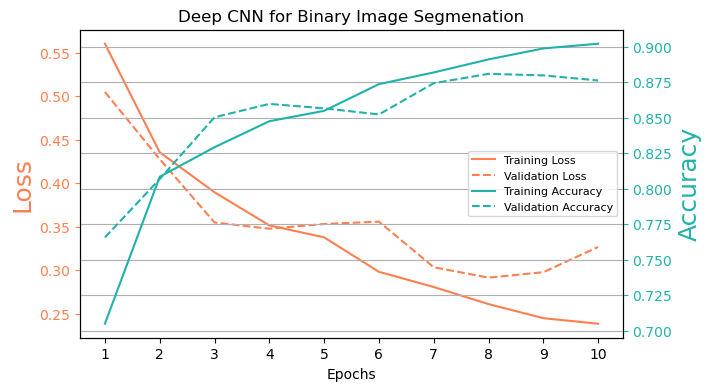

In [66]:
def plot_training_history(model_history_object, model_name=''):
    # Extract the training history dictionary
    hist_dict = model_history_object.history
    # Plot
    plt.figure(figsize=(7, 4))
    loss_color = 'coral'
    # Plot Loss on the primary y-axis
    loss_plot, = plt.plot(hist_dict['loss'],
                          label='Training Loss', color=loss_color)
    val_loss_plot, = plt.plot(hist_dict['val_loss'],
                              label='Validation Loss', color=loss_color, linestyle='--')
    
    # Label for the primary y-axis (Loss)
    plt.ylabel('Loss', color=loss_color, fontsize=18)
    plt.gca().tick_params(axis='y', colors=loss_color)
    ticks = range(0, len(hist_dict['loss'])+1)
    plt.xticks(ticks=ticks, labels=[x+1 for x in ticks])
    plt.xlabel('Epochs')  # X-axis label
    plt.title(model_name)
    
    # Create a secondary y-axis for Accuracy
    acc_color = 'lightseagreen'
    ax2 = plt.gca().twinx()
    train_acc = hist_dict.get('accuracy', hist_dict.get('acc'))
    val_acc = hist_dict.get('val_accuracy', hist_dict.get('val_acc'))
    accuracy_plot, = ax2.plot(train_acc,
                              label='Training Accuracy', color=acc_color)
    val_accuracy_plot, = ax2.plot(val_acc,
                                  label='Validation Accuracy', color=acc_color, linestyle='--')
    ax2.set_ylabel('Accuracy', color=acc_color, fontsize=18)
    ax2.tick_params(axis='y', colors=acc_color)
    
    plt.grid()
    lines = [loss_plot, val_loss_plot, accuracy_plot, val_accuracy_plot]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels, loc='right', fontsize=8);

plot_training_history(history_model_deepcnn, model_name="Deep CNN for Binary Image Segmenation")

Run the cell below, and you will see your segmentation result. You can run the cell multiple times to see different result sets.

In [67]:
for x, y in train_dataset.take(1):
    print(x.shape)  # should be (BATCH_SIZE, 64, 64, 3)
    print(y.shape)  # should be (BATCH_SIZE, 64, 64, 1)
    print(tf.reduce_min(y), tf.reduce_max(y))  # should be 0.0 and 1.0

(16, 64, 64, 3)
(16, 64, 64, 1)
tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(1, shape=(), dtype=int32)


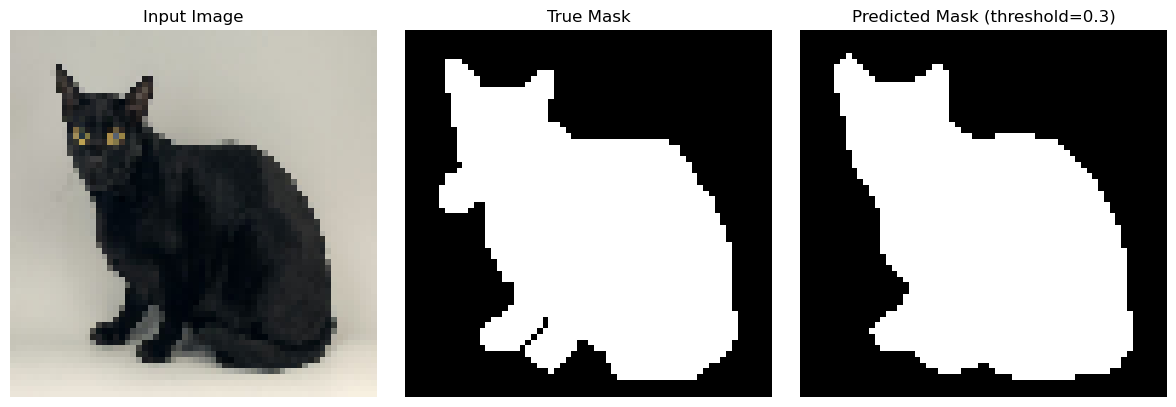

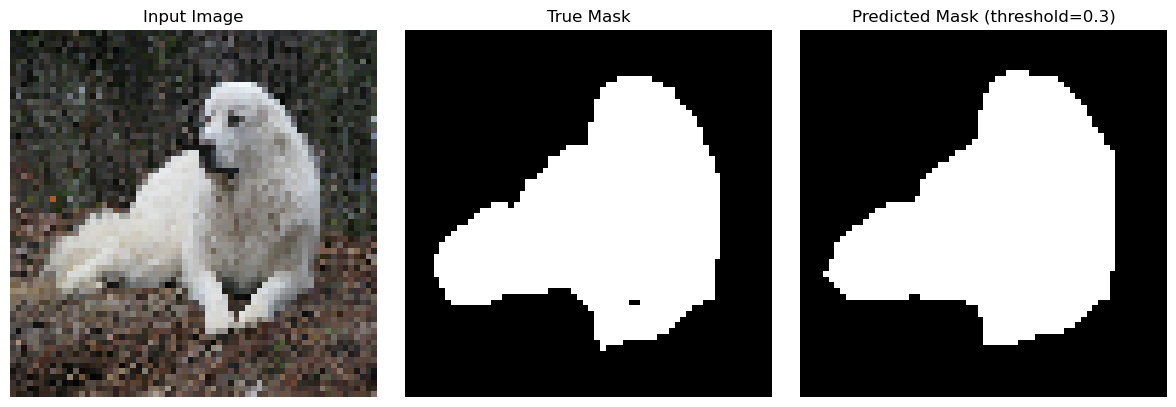

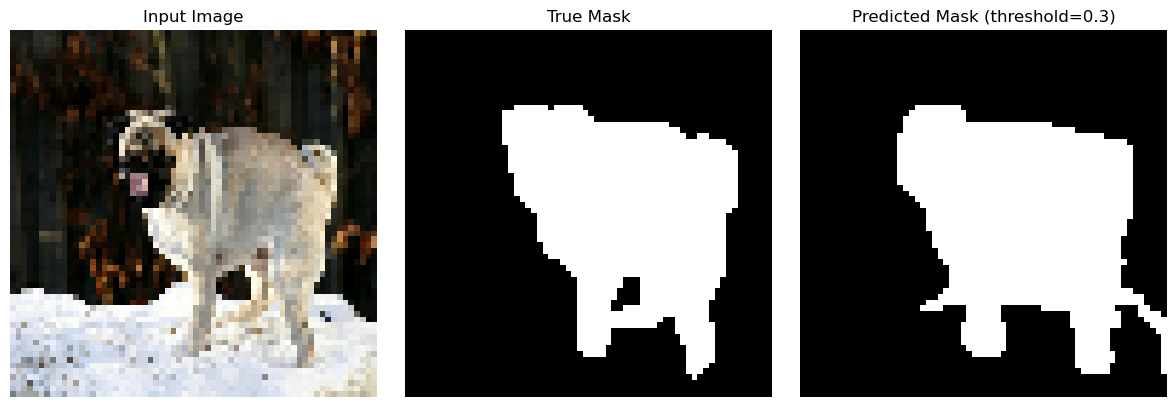

In [68]:
visualize_predictions_with_threshold(ds_2c_test, model_deepcnn, threshold = 0.3)

Checking model predictions...
Sample 1: Contains non-zero predictions: True
   Prediction range: Min=0.0000, Max=0.9991
Sample 2: Contains non-zero predictions: True
   Prediction range: Min=0.0000, Max=0.9994
Sample 3: Contains non-zero predictions: True
   Prediction range: Min=0.0000, Max=0.9986
Sample 4: Contains non-zero predictions: True
   Prediction range: Min=0.0000, Max=0.9995
Sample 5: Contains non-zero predictions: True
   Prediction range: Min=0.0023, Max=0.9857

Visualizing with lower threshold...


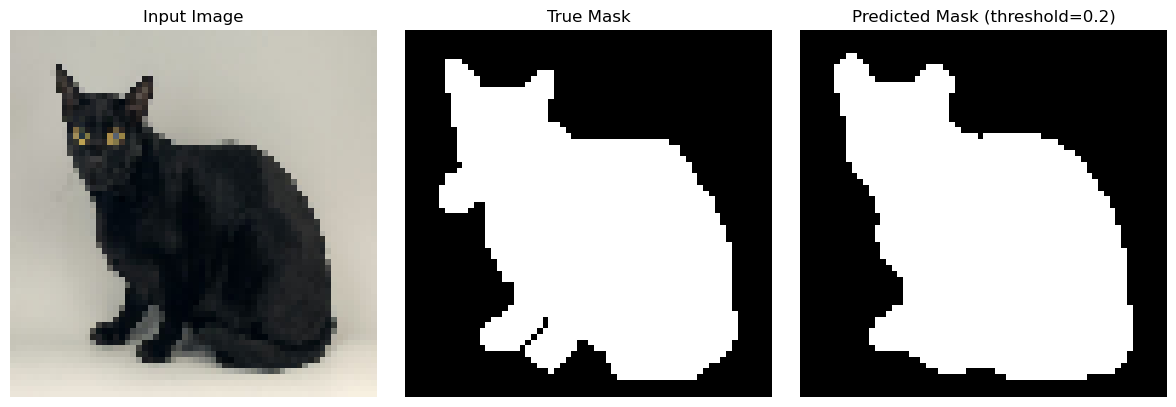

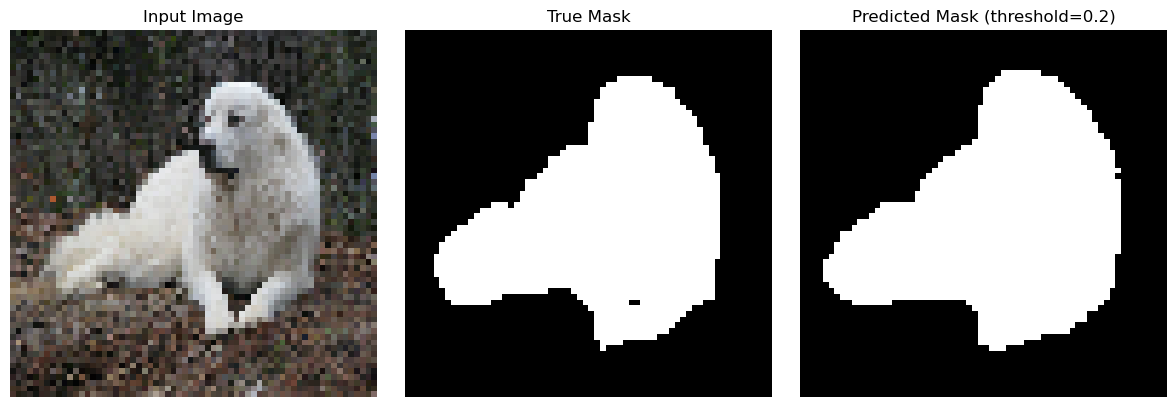

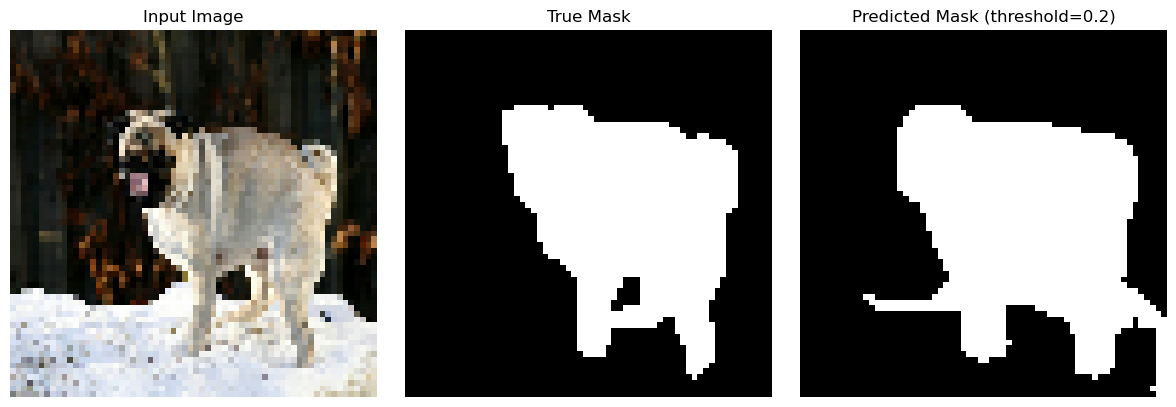


Original visualization (likely using threshold=0.5):


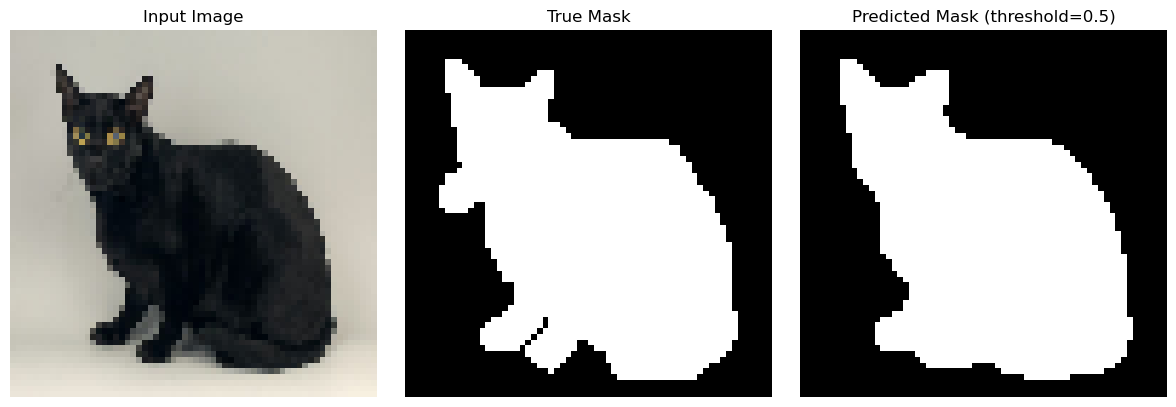

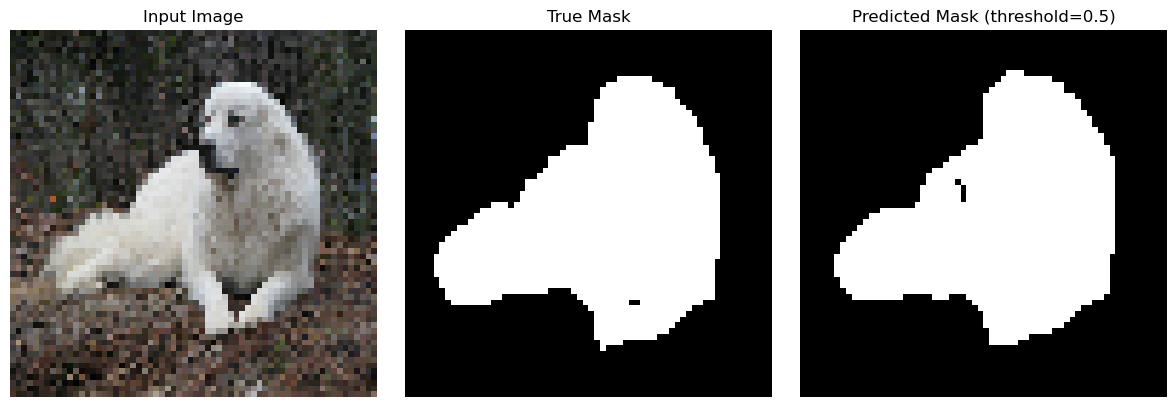

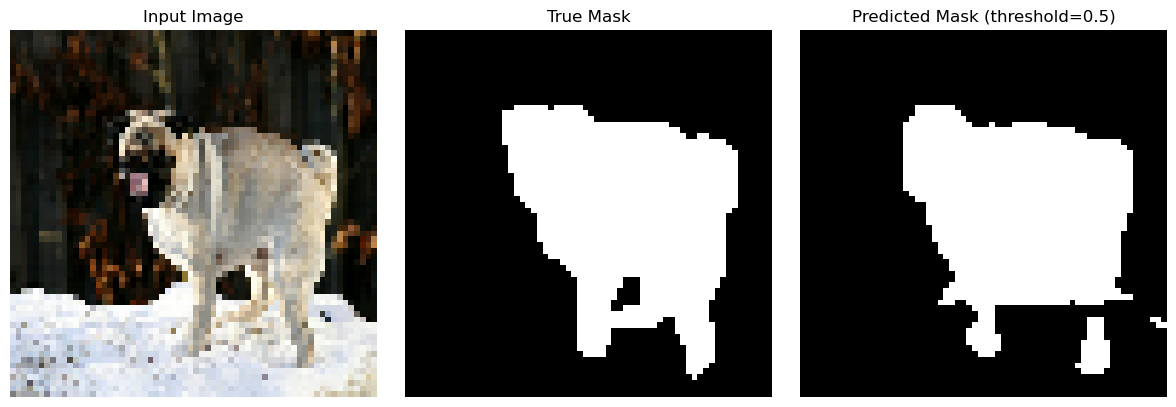

In [69]:
### CHECK CELL 

#### First, let's check if the model is actually predicting anything other than zeros
def check_model_predictions(dataset, model, num_samples=5):
    """Check if model predictions contain any non-zero values"""
    for i, (image, true_mask) in enumerate(dataset.take(num_samples)):
        # Get prediction
        pred_mask = model.predict(tf.expand_dims(image, 0), verbose=0)
        pred_mask = tf.squeeze(pred_mask)
        
        # Check if prediction contains any non-zero values
        has_nonzero = tf.math.reduce_any(pred_mask > 0.5)
        print(f"Sample {i+1}: Contains non-zero predictions: {has_nonzero.numpy()}")
        print(f"   Prediction range: Min={tf.reduce_min(pred_mask).numpy():.4f}, Max={tf.reduce_max(pred_mask).numpy():.4f}")
        
        # If all predictions are near 0 or 1, the model might be too confident but wrong
        if tf.reduce_max(pred_mask).numpy() < 0.1:
            print("   Model is predicting all pixels as background (class 0)")

# Check model predictions
print("Checking model predictions...")
check_model_predictions(ds_2c_test, model_deepcnn)

# If the model is predicting all zeros, try these solutions:
# 1. Verify the training data is balanced
# 2. Check if model weights are properly initialized
# 3. Try a lower threshold for visualization (the default might be 0.5)

# Visualize with a lower threshold to see if there's any signal
def visualize_predictions_with_threshold(dataset, model, threshold=0.3, num_samples=3):
    """Visualize model predictions with a custom threshold"""
    for i, (image, true_mask) in enumerate(dataset.take(num_samples)):
        # Get prediction
        pred_mask = model.predict(tf.expand_dims(image, 0), verbose=0)
        pred_mask = tf.squeeze(pred_mask)
        
        # Apply threshold
        pred_mask_binary = tf.cast(pred_mask > threshold, tf.float32)
        
        # Plot
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("True Mask")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_binary, cmap='gray')
        plt.title(f"Predicted Mask (threshold={threshold})")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

# Try visualizing with a lower threshold
print("\nVisualizing with lower threshold...")
visualize_predictions_with_threshold(ds_2c_test, model_deepcnn, threshold=0.2)

# Now show the original visualization for comparison
print("\nOriginal visualization (likely using threshold=0.5):")
visualize_predictions_with_threshold(ds_2c_test, model_deepcnn, threshold = 0.5)

<div class='exercise'><b>[209] Q3.2 U-Net for 3-Class Image Segmentation</b>

<a id="q32"></a>  
This question is required for 209 students but optional for others. Extra credit will not be given if attempted by non-209 students, but you may learn something new! :) 

In the previous model, the predictions were limited because we had to maintain the same dimensions throughout. This restricted the ability to capture different levels of detail. To address this, we introduce a new architecture: **U-Net**.  

U-Net is a segmentation model originally designed for biomedical image segmentation. It follows an encoder-decoder structure with skip connections, allowing it to capture both fine details and high-level semantic features. This structure makes U-Net highly effective for pixel-wise classification. To learn more, please see:

- [ED Slides and Notebook](https://edstem.org/us/courses/74185/lessons/133380/slides/750646)
- **Reference Paper:** [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597)  

You will build a U-Net model that takes a 64 × 64 × 3 image as input and classifies each pixel into one of three categories:  
- Background  
- Border-of-Pet
- Pet  

In the previous model, accuracy was used as a metric. However, for segmentation tasks, accuracy can be misleading. A model predicting all pixels as "background" could still appear accurate if there is a data imbalance. Instead, consider exploring alternative metrics. 
Refer to the links above for different approaches.  

Minimum Requirements: \
To complete this task successfully, your model must:  
- Follow an encoder-decoder architecture.  
- Accept 64 × 64 × 3 input images and perform pixel-level 3-class classification.  
- Include exactly three downsampling operations in the encoder, reducing the size as follows:  
  - 64 -> 32 -> 16 -> 8  
- Use a decoder that mirrors the encoder, upsampling back to 64 × 64.  
- Implement at least three skip connections appropriately.  
- Compile with an appropriate loss function and include accuracy as an evaluation metric.  
- Name your model `model_unet`.  
- Assign the result of `model_unet.fit()` to a named `history_model_unet`.  


With a well-optimized model following the requirements above, you should be able above 80% validation accuracy within 4-5 minutes of training. If training takes significantly longer or the model performs poorly, you should inspect your the architecture and/or loss function.
</div>

In [70]:
# Create processed 3-class segmentation dataset
ds_3c = ds_source.map(lambda sample: preprocess(sample, reduce_class=False),
                               num_parallel_calls=tf.data.AUTOTUNE)

# 85/15 train-test split
ds_3c_train, ds_3c_test = tf.keras.utils.split_dataset(ds_3c, left_size=0.85)
# Reserve 20% of train as validation
ds_3c_train, ds_3c_val = tf.keras.utils.split_dataset(ds_3c_train, left_size=0.80)

# Dataset sizes
print("Train:", ds_3c_train.cardinality().numpy())
print("Validation:", ds_3c_val.cardinality().numpy())
print("Test:", ds_3c_test.cardinality().numpy())

Train: 2495
Validation: 624
Test: 550


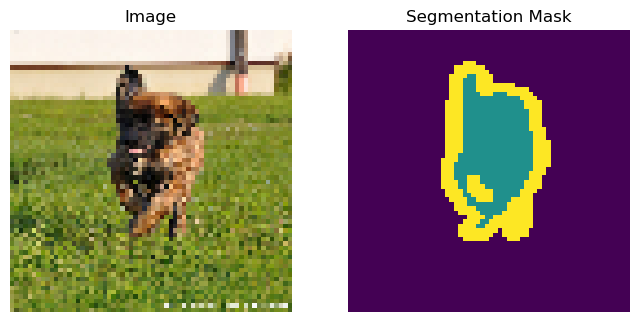

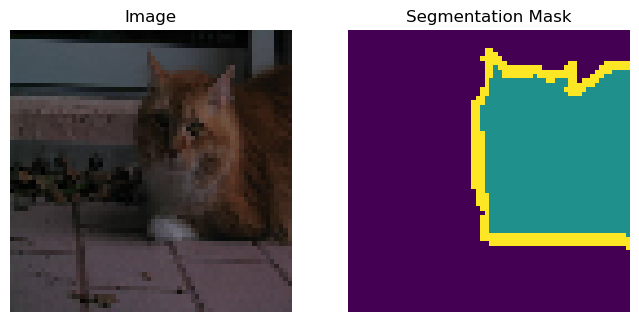

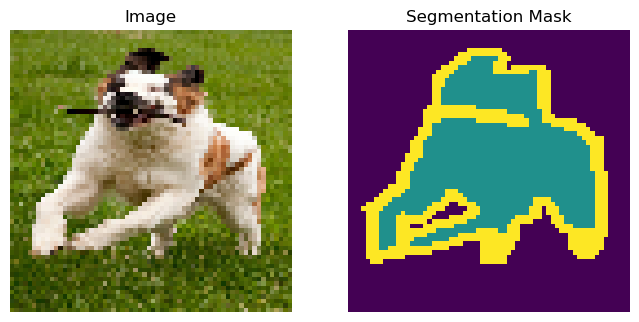

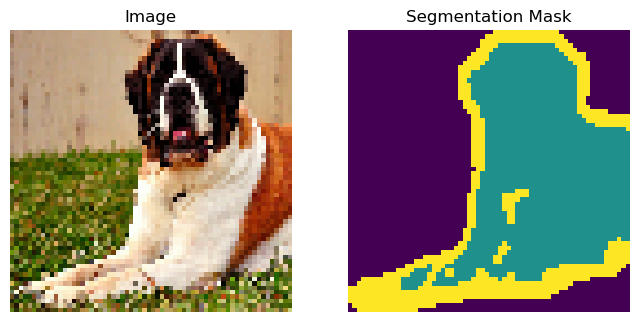

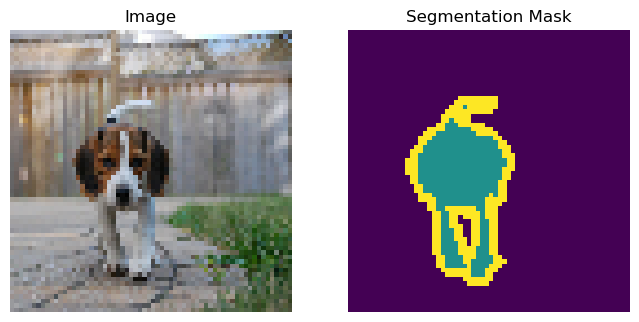

In [71]:
# Visualize 5 examples from the training split
visualize_image_and_mask(ds_3c_train)

In [72]:
# your code here
...

Run the cell below to visualize your loss and accuracy.

In [73]:
plot_training_history(history_model_unet,
                      model_name="U-Net for 3-Class Image Segmentation")

NameError: name 'history_model_unet' is not defined

Run the cell below, and you will see your segmentation result. You can run the cell multiple times to see different result sets.

In [ ]:
visualize_predictions(ds_3c_test, model_unet, show_iou=True)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Wrap-up</b>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.
    </div>


The hardest part of this pset by far was Q3. At first, when using sigmoid, the predicted mask was just the majority class (the background pixels) so the resulting image was a black square. We tried to use softmax activation function but kept running into loss = NaN issues and then also there were some dimensionality problems with the final layers in the model that took a long time to solve. 

After meeting with Rasthmi and telling her about the lowered threshold visualization function and how that helped tremendously with the sigmoid activation, she said that was fine to do. But it still took a long time for us to figure this out! 

In [77]:
hours_spent_on_hw = 15

In [78]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [79]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 40.29 minutes for this notebook to run


**This concludes HW3. Thank you!**